In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from tensorflow.keras import optimizers

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')



import warnings
warnings.filterwarnings("ignore")

## **Introduction**

Cifar-10 dataset contains 60,000 color images of 32 x 32 . It consists of 60,000 images of 10 classes. In total there are 50,000 training images and 10,000 test images. The dataset is divided into 6 parts – 5 training batches and 1 test batch. Each batch has 10,000 images.

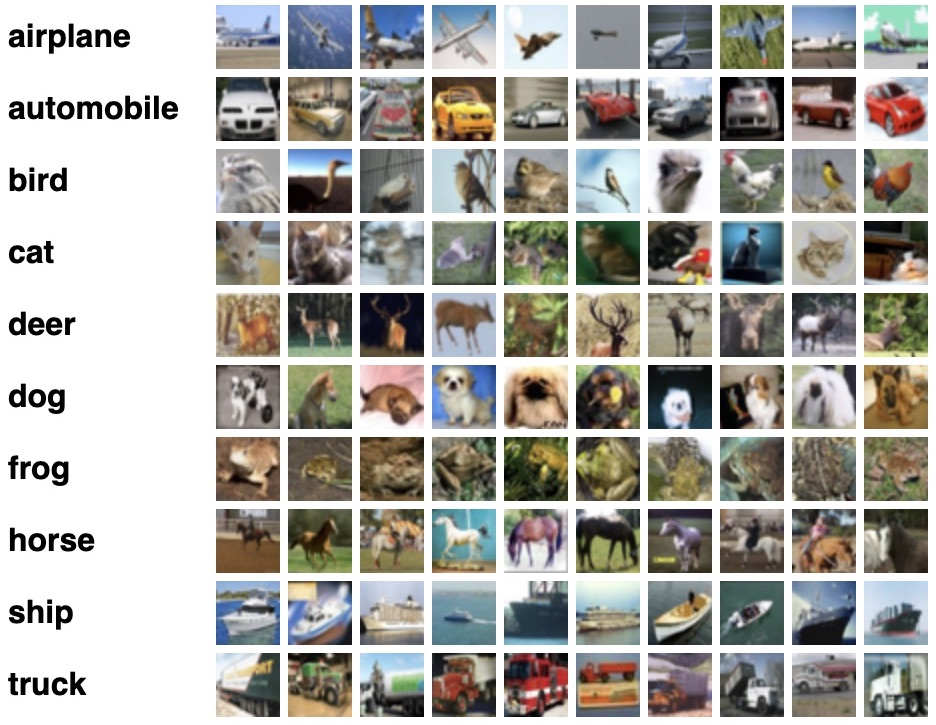

## **Objective** 

The goal is to identify previously unseen images and classify them into one of ten categories.

## **1. Load and prepare the data**


In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

### Data Exploration
Check the shape of the training and testing data

In [4]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


- There are 50,000 images under the training set & 10,000 images under the testing set.
- The 32 represents the dimensions of the images of the Cifar-10 data

In [5]:
print (np.max(x_train))
print (np.min(x_train))

255
0


0 is the minimum and 255 is the maximum value of pixels that form the Cifar-10 images.

## **2. Data Visualization**

### Distribution Of Data

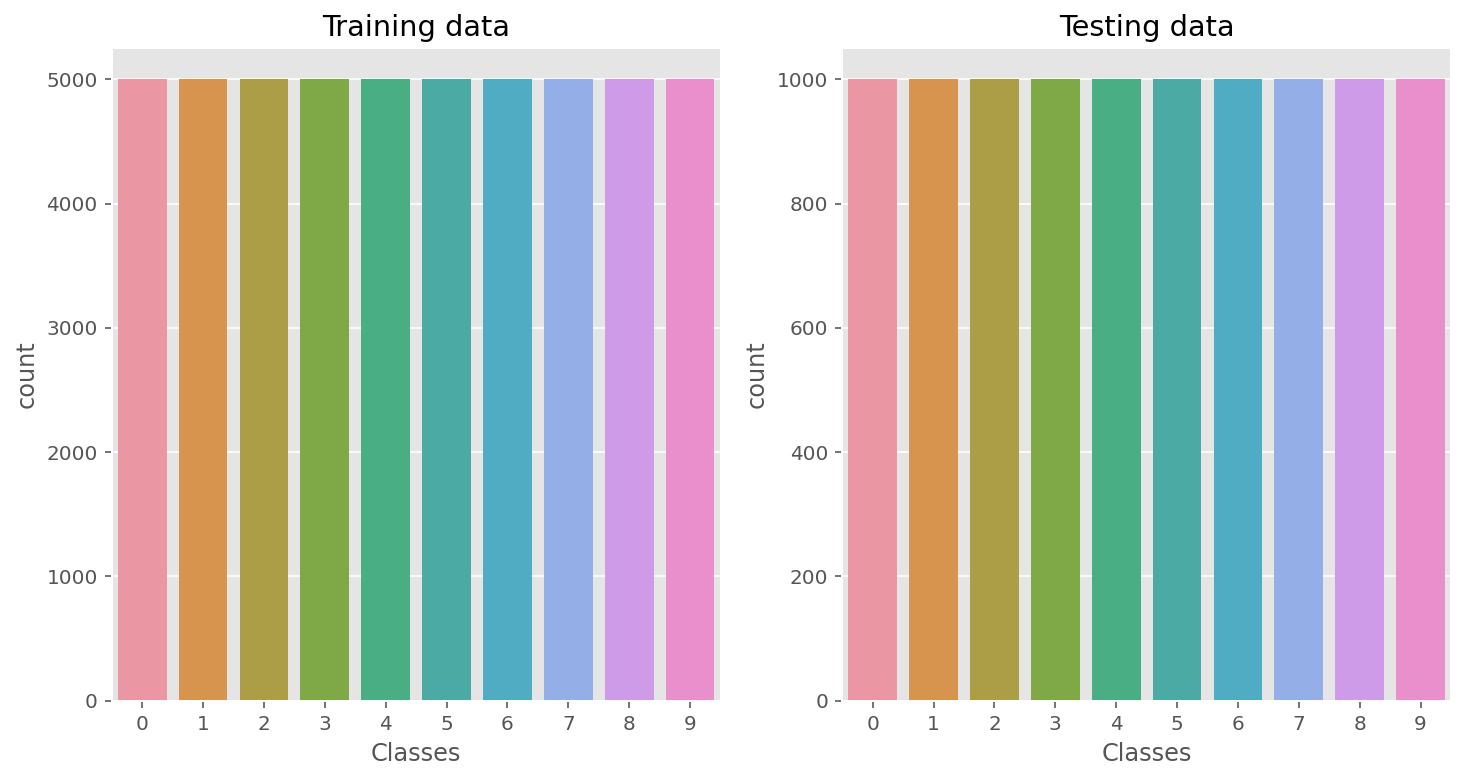

In [6]:
fig, axs = plt.subplots(1,2,figsize=(12,6)) 

# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Training data')
axs[0].set_xlabel('Classes')

# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Testing data')
axs[1].set_xlabel('Classes')
plt.show()


As seen in the countplot, the distrubution of the data shows that each class has a total of 6000 samples ( 5000 for training and 1000 for test) which implies its accurate.

## Visualization Of Samples

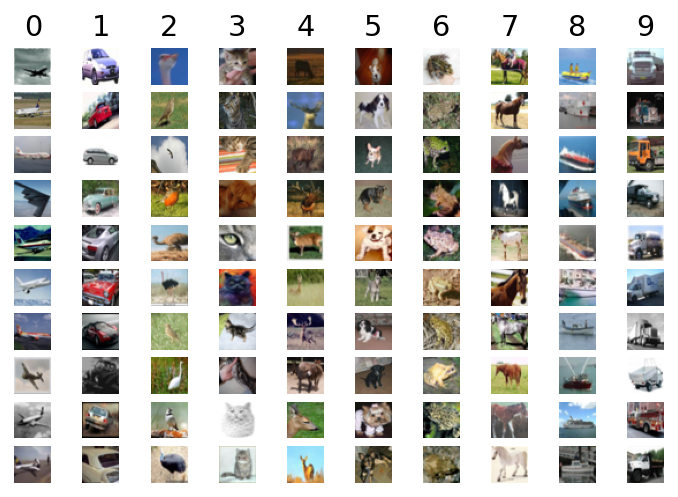

In [7]:
examples_per_class = 10 # Number of examples you want to see from each class
num_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # Number of classes shown

for cls, cls_name in enumerate(num_classes):
  idxs = np.where(cls == y_train)
  idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
    plt.imshow(x_train[idx].astype('uint8'), cmap = 'gray')
    plt.axis('off')
    if i == 0:
      plt.title(cls_name)

A visualisation of each sample from 10 different classes

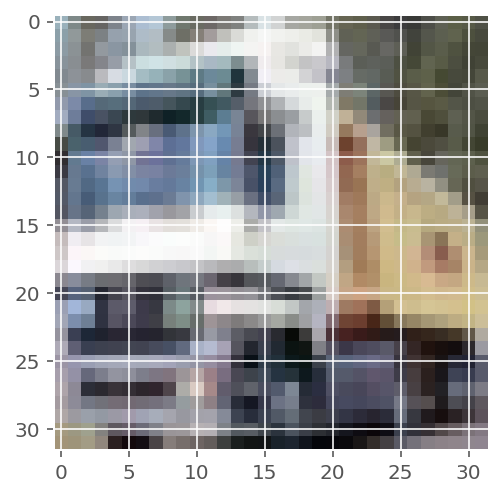

In [8]:
plt.imshow(x_train[1])

Visualisation of a sample from the "truck" class

## **3. Data Preprocessing**

## Normalization

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Data is normalized as it helps in the optimisation process. Data is needed to tranformed to float for optimisation.

In [10]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


## One-Hot Encoding

In [11]:
y_train = keras.utils.np_utils.to_categorical(y_train, len(num_classes))
y_test = keras.utils.np_utils.to_categorical(y_test, len(num_classes))

One hot encoding is applied to convert class vectors to binary class matrices to compute loss

In [12]:
print (y_test.shape)
print (y_test[:3,:])

(10000, 10)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


## **4. Building the Model Architectures Using CNN/ConvNets**

1. Convolution
2. Non-linearity activation
3. Pooling


Stage 1 : The neural network will learn 32 convolutional filters in the first step, each having a 3 × 3 size. The output dimension is the same as the input shape, so it will be 32 × 32, with relu activation, which is a technique that introduce non-linearity. Then there are additional 32 convolutional filters, each with a 3 x 3 size and relu activation. Following that, there will be a max-pooling operation with a pool size of 2 × 2 and a 25% dropout.

Stage 2 : In the second stage. The neural network will learn 64 convolutional filters, each with a size of 3 x 3. The output dimension is the same as the input shape, with relu activation. This is followed by additional 64 convolutional filters, each with a 3 x 3 size and relu activation. Following that, there will be a max-pooling operation with a pool size of 2 × 2 and a 25% dropout.

Stage 3 : A dense network with 512 units and relu activation is used in the third stage, which is followed by a dropout at 50% and a softmax layer with 10 classes as output, one for each category.

In [13]:
# To Define Convnet
model = Sequential()

In [14]:
# Stage 1 : CONV => RELU => CONV => RELU => POOL => DROPOUT

model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stage 2 : CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Stage 3: FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# a softmax classifier
model.add(keras.layers.Dense(len(num_classes), activation='softmax')) 

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

## **5. Model Training**

### Setting the model hyperparameters 

In [16]:
batch_size = 32  # The default batch size of keras
num_classes = 10  # Number of class for the dataset
epochs = 100 # Number of epochs running
data_augmentation = False

### RMSprop optimizer

In [17]:
# Defining RMSprop Optimizer
optzr = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

In [18]:
# Training the model using RMSprop
model.compile(optimizer= optzr, # optimizing the loss function 
              loss='categorical_crossentropy', # to measure how good the network is
              metrics=['accuracy']) # #accuracy of the classification

- RMSprop : Root Mean Square Prop
- Loss function : To determine how good a model is.
- Optimizer: To update the network as additional data comes in, lowering the loss value.
- Metrics: To see accuracy of the network performance.

### Data Augmentation & Model Log History

To avoid overfitting, data augmentation is added to the model. The dataset must be expanded to avoid overfitting. Cropping, Rotating, Scaling, Translating, Flipping, and Adding Noise are some of the image augmentation techniques used on the training data.

In [19]:
if not data_augmentation:
    print('Data augmentation not in use')
    model_log = model.fit(x_train, y_train, # number of samples to be used for each gradient update
              batch_size=batch_size, # total number of iterations on the x train data
              epochs=epochs, # validation data to evaluate loss and model metrics
              validation_data=(x_test, y_test),  # to evaluate loss and model metrics at the end of each epoch
              shuffle=True) # shuffling of data
else:
    print('Real-time data augmentation in use')
    # Preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor 
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # quantities required for feature-wise normalization
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model_log = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4)

Data augmentation not in use
Epoch 1/100
1563/1563 [==============================] - 87s 55ms/step - loss: 1.8237 - accuracy: 0.3304 - val_loss: 1.5311 - val_accuracy: 0.4370
Epoch 2/100
1563/1563 [==============================] - 98s 63ms/step - loss: 1.4974 - accuracy: 0.4567 - val_loss: 1.3866 - val_accuracy: 0.5102
Epoch 3/100
1563/1563 [==============================] - 88s 57ms/step - loss: 1.3715 - accuracy: 0.5080 - val_loss: 1.2697 - val_accuracy: 0.5506
Epoch 4/100
1563/1563 [==============================] - 84s 54ms/step - loss: 1.2728 - accuracy: 0.5469 - val_loss: 1.1644 - val_accuracy: 0.5955
Epoch 5/100
1563/1563 [==============================] - 84s 54ms/step - loss: 1.1981 - accuracy: 0.5791 - val_loss: 1.1638 - val_accuracy: 0.5863
Epoch 6/100
1563/1563 [==============================] - 83s 53ms/step - loss: 1.1286 - accuracy: 0.6014 - val_loss: 1.0600 - val_accuracy: 0.6244
Epoch 7/100
1563/1563 [==============================] - 81s 52ms/step - loss: 1.0764 - a

## 6. Model Evaluation

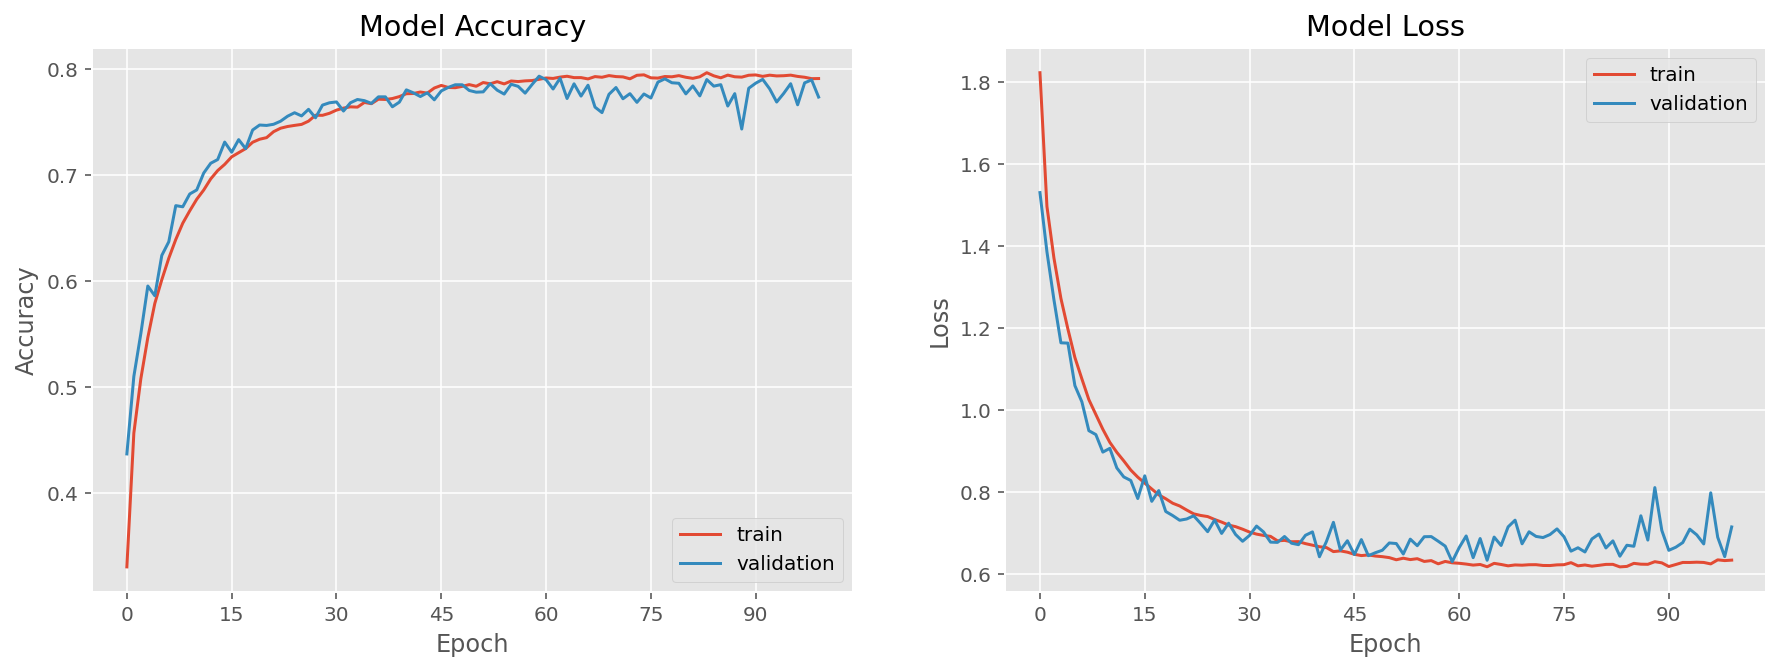

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Model Accuracy') #Higher is better
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Model Loss') #Lower is better
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

As seen in both plots, the model's accuracy does not improve significantly after 60 epochs. The model doesn't show any overfitting.

In [22]:
# Training model scores
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 3s 11ms/step - loss: 0.7151 - accuracy: 0.7739
Test loss: 0.7150523066520691
Test accuracy: 0.7738999724388123


## 6. Image Classification

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

### Confusion Matrix

In [49]:
y_test_arg=np.argmax(y_test,axis=1)
pred = np.argmax(model.predict(x_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, Y_pred))

cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

Confusion Matrix
[[706   9  75  18  29   4  20  11 106  22]
 [ 11 868   2   4   0   6  16   0  42  51]
 [ 37   1 689  40  61  32 108  21  10   1]
 [  9   1  92 565  50 129 107  29  13   5]
 [  9   2  51  39 755  21  74  40   8   1]
 [  2   0  66 135  35 687  38  33   4   0]
 [  3   0  38  23  15   8 902   4   7   0]
 [  7   0  41  37  56  43  13 797   3   3]
 [ 24   8  13   4   2   5   6   4 923  11]
 [ 19  45  15   8   7   7   9  12  31 847]]


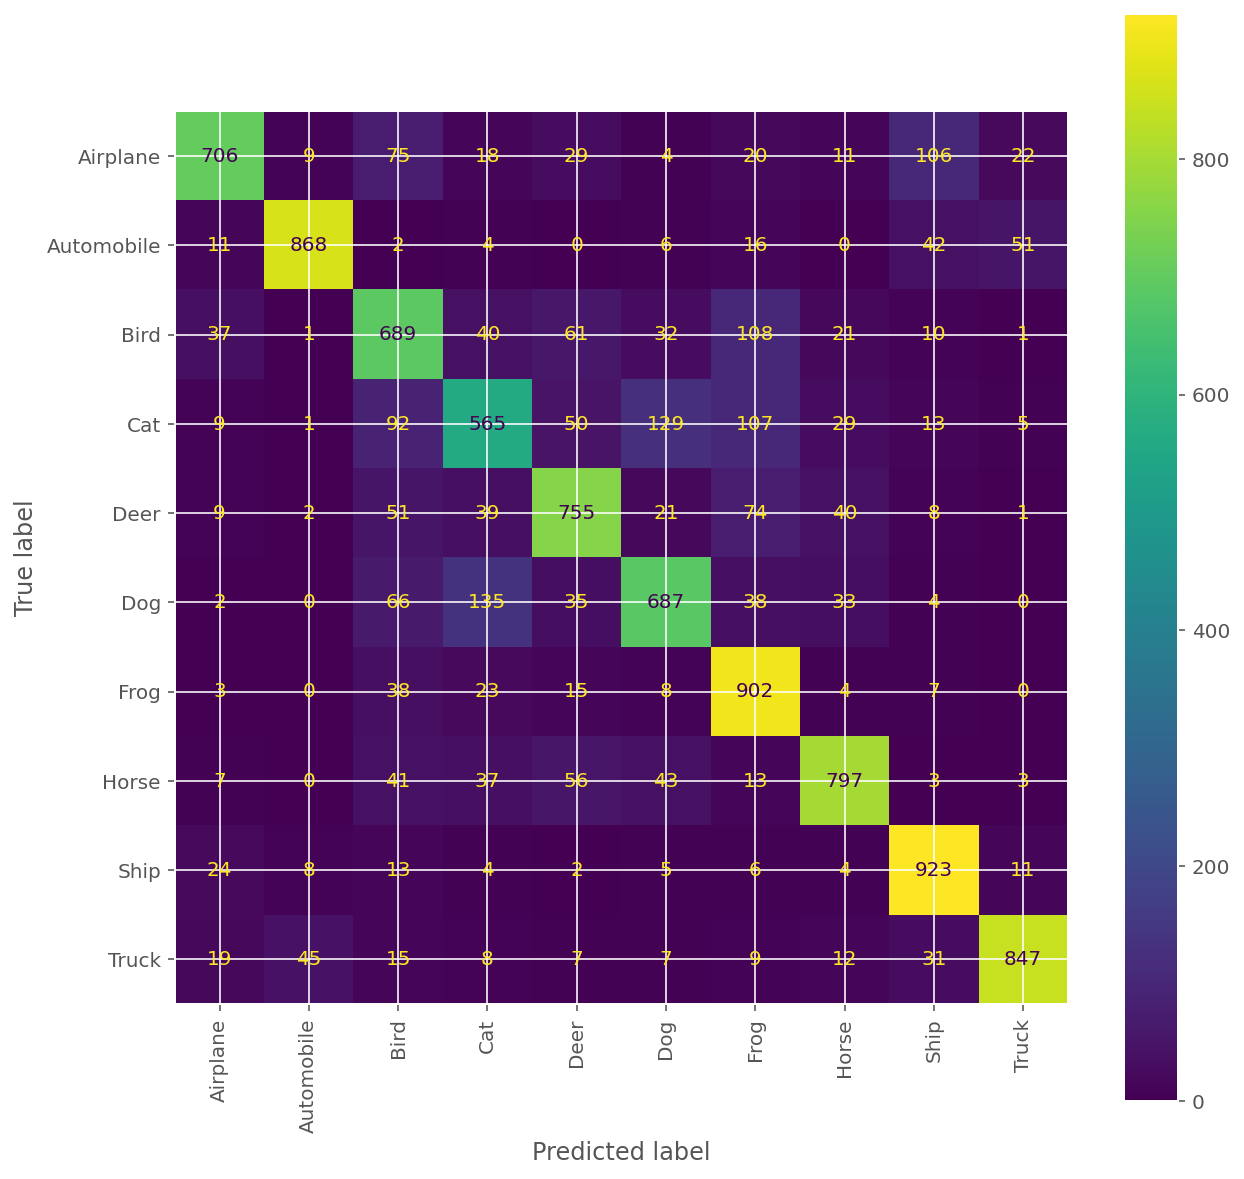

In [129]:
# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10))
cm = disp.plot(xticks_rotation='vertical', ax=ax,cmap='viridis')

plt.show()


As seen in the confusion matrix, the true labels are highly correlated with its predicted labels.

### Classification Report

In [138]:
print(classification_report(y_test_arg, Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.71      0.77      1000
           1       0.93      0.87      0.90      1000
           2       0.64      0.69      0.66      1000
           3       0.65      0.56      0.60      1000
           4       0.75      0.76      0.75      1000
           5       0.73      0.69      0.71      1000
           6       0.70      0.90      0.79      1000
           7       0.84      0.80      0.82      1000
           8       0.80      0.92      0.86      1000
           9       0.90      0.85      0.87      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



As seen in the classification report, the classes has high precision, recall & f1-score implying good accuracy.

### Testing on Individual Images

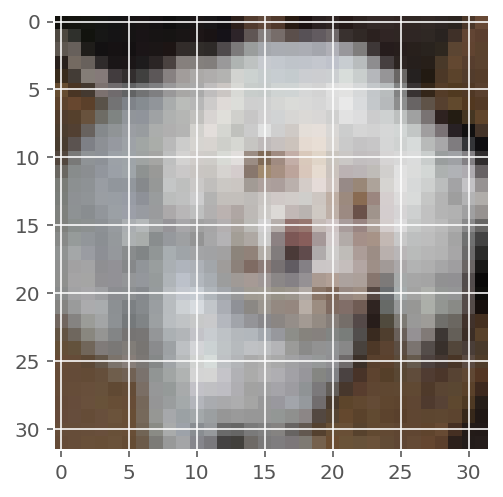

In [163]:
image = x_test[1000]
plt.imshow(image)

In [168]:
# Image shows a Dog
y_test_arg[1000]

5

In [169]:
# Image is correctly predicted as a Dog
np.argmax(model.predict(image.reshape(1, 32, 32, 3)))

5

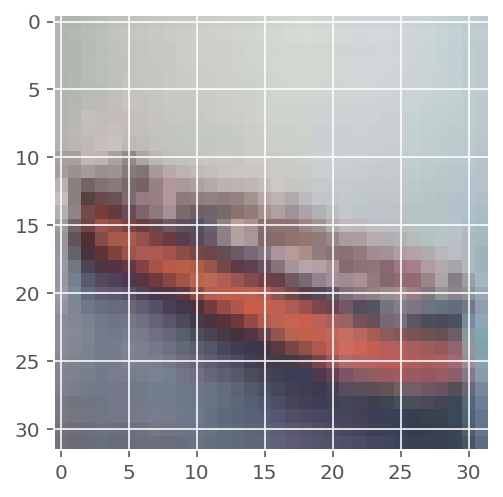

In [170]:
image = x_test[999]
plt.imshow(image)

In [171]:
# Image shows a Boat
y_test_arg[999]

8

In [172]:
# Image is correctly predicted as a Boat
np.argmax(model.predict(image.reshape(1, 32, 32, 3)))

8

### Correct Predictions on Images

In [186]:
# Define the labels of the dataset
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

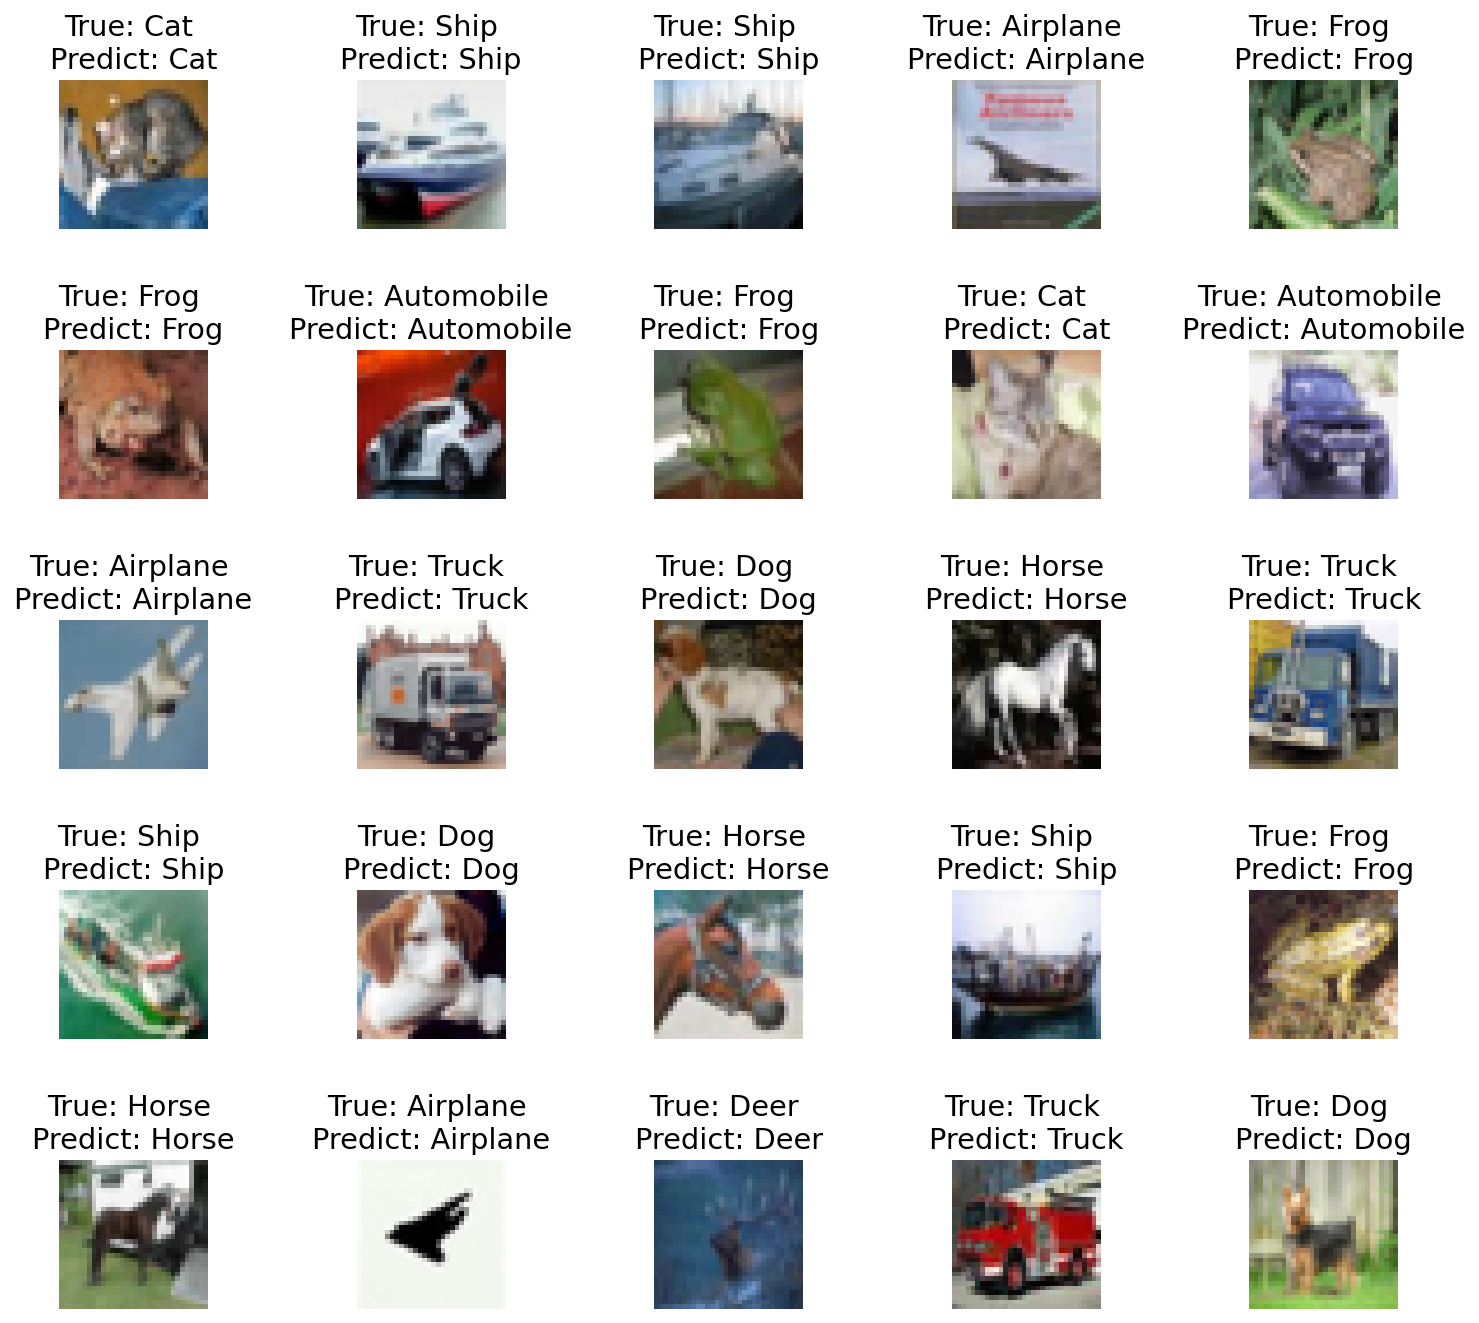

In [187]:
Rows = 5
Columns = 5

fig, axes = plt.subplots(Rows, Columns, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, Rows*Columns):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[y_test_arg[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

### Wrong Predictions on Images

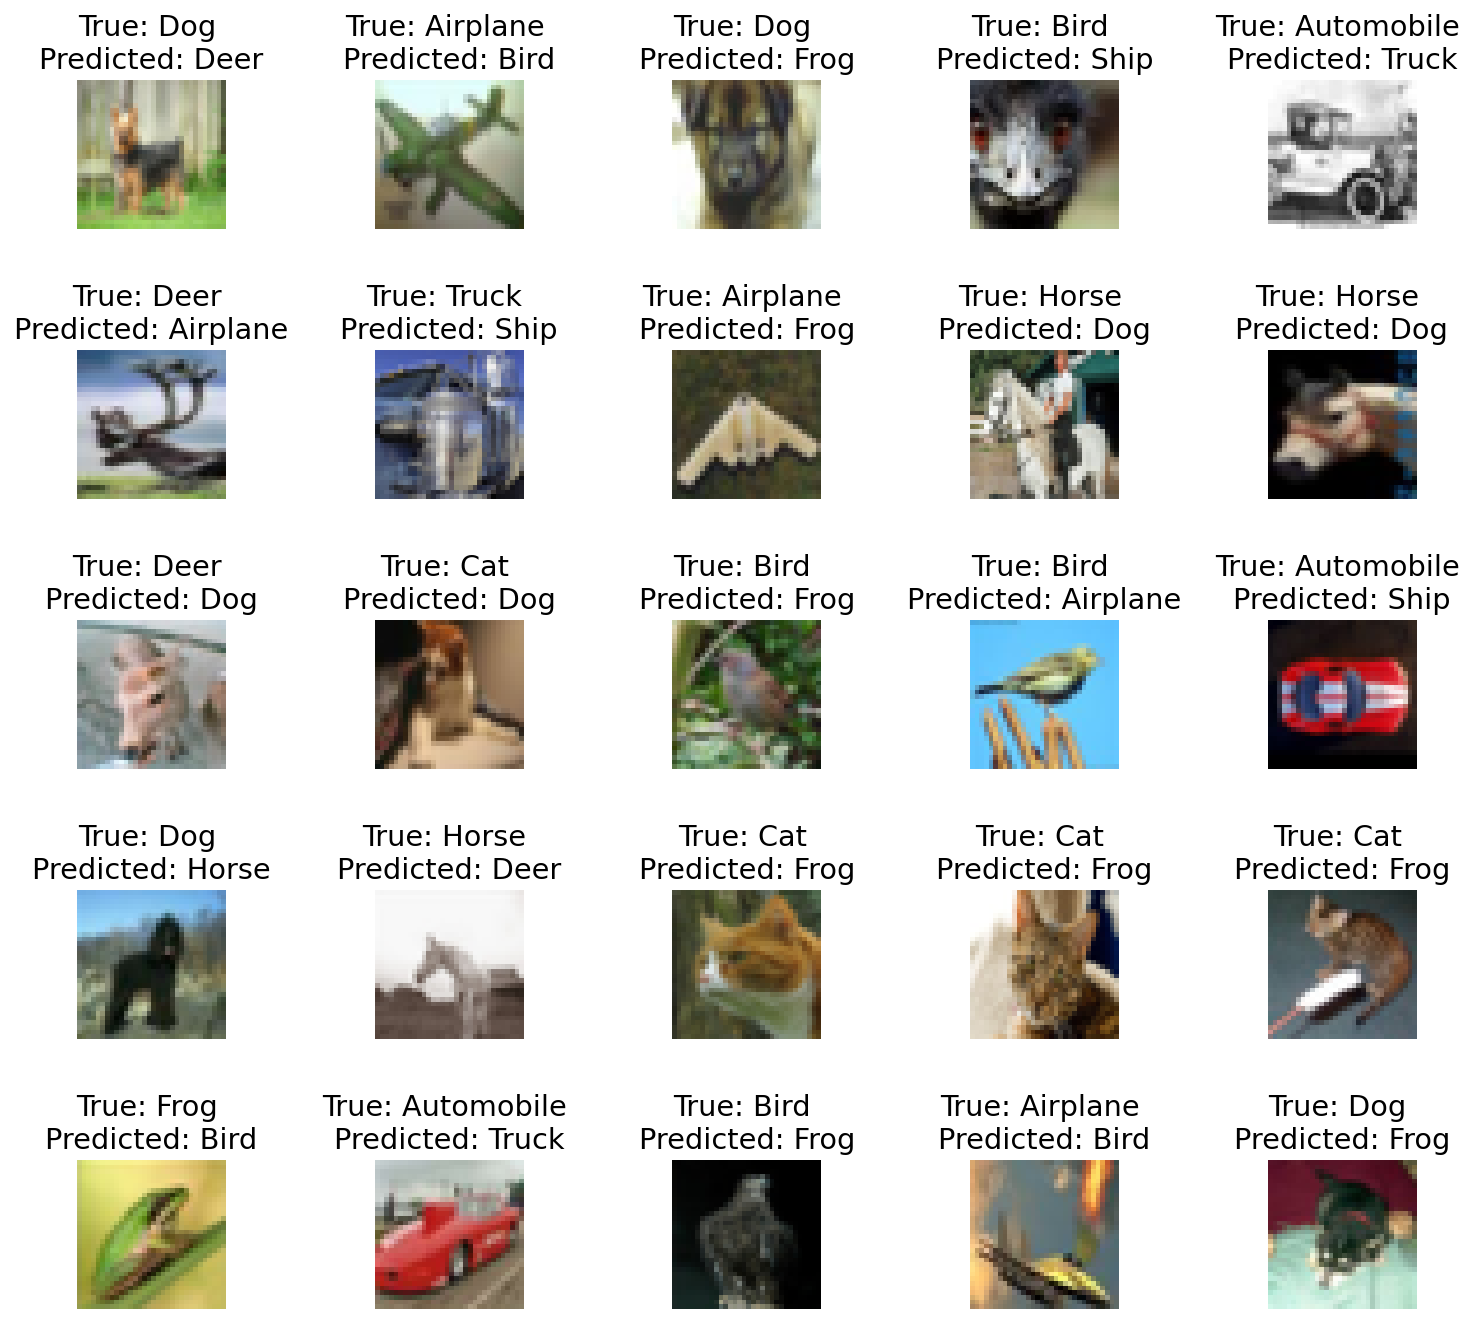

In [188]:
Rows = 5
Columns = 5
fig, axes = plt.subplots(Rows, Columns, figsize=(12,12))
axes = axes.ravel()

misclassified= np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified[i]]], 
                                                  labels[Y_pred_classes[misclassified[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

## 7. Saving Of Model

In [195]:
from tensorflow.keras.models import load_model

model.save('cifar10_trained_model.h5')